# Tesco Creative Extension Project <a class="anchor" id="index"></a>

## Table of Contents:


1. [Useful functions](#first-bullet)
    * [normalize](#normalize)
    * [inverse](#inverse)
    * [update_wards](#Update_wards)
    
    
2. [Data Pre-Processing](#second-bullet)   
    * [Import Data](#import)
    * [Housing](#house)
    * [Income](#income)
    * [Jobs](#jobs)
    * [Community](#community)
    * [Education](#education)
    * [Environment](#env)
    * [Civic Engagement](#civic)
    * [Health](#health)
    * [Life Satisfaction](#satisfaction)
    * [Safety](#safety)
    * [Work-Life Balance](#balance)
    * [Food](#food)
    * [Alcohol](#alcohol)


3. [Principal Component Analysis](#3-bullet)
    * [More functions](#pca_functions)
        * [correlations_heatmap](#correlations_heatmap)
        * [calculate_weights](#calculate_weights)
        * [calculate_index_for_df](#calculate_index_for_df)
    * [Computing the weights of the sub-indicators](#weights1)
    * [Computing the weights of the indicators](#weights2)
    * [Validation](#validation)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

## 1. Useful functions data preprocessing <a class="anchor" id="first-bullet"></a>
In this section we define useful functions to help us in our data preprocessing pipeline:

* [normalize](#normalize)
* [inverse](#inverse)
* [update_wards](#Update_wards)



<a class="anchor" id="normalize"></a>
Function `normalize` allows to choose between 'standardize' $\dfrac{x - mean(x)}{std(x)}$ or 're_scale'  $\dfrac{x - min(x)}{max(x) - min(x)}$, also can remove outliers by fixing values smaller than the 2.5 percentile or bigger thant the 97.5 percentile to those respective values.  

[Back to index](#index)

In [2]:
#function that will allow us to normalize the data, using different methods, and remove outliers (or not).

def normalize(df,method='standardize', remove_outliers = True):
    data  = df.copy()
    start = 1
    if 'Names' in data.columns:
        start = 2    
    for i,col in enumerate(data.columns[start:]) :
        if remove_outliers :
            data.loc[:,col] = data.loc[:,col].clip(lower = data.loc[:,col].quantile(0.025))
            data.loc[:,col] = data.loc[:,col].clip(upper = data.loc[:,col].quantile(0.975))
        if method == 'standardize' :
            data.loc[:,col] = (data.loc[:,col] - data.loc[:,col].mean())/data.loc[:,col].std()
        elif method == 're_scale' :
            data.loc[:,col] = ((data.loc[:,col] - data.loc[:,col].min()) / (data.loc[:,col].max() - data.loc[:,col].min()))
        else : print('Warning, unknown method ', method)
    return data

<a class="anchor" id="inverse"></a>
Function `inverse` that allows to get the complement of selected columns in a dataset: $1 - x$

[Back to index](#first-bullet)

In [3]:
# It will happen that we want to inverse some fields in our data sets, to be consistent
def inverse(df, columns = []) :
    if not columns : #if no columns specified apply to all 
        columns =  df.columns[df.columns != 'area_id']
        if 'Names' in df.columns:
            columns = columns[columns != 'Names']
    else : columns = pd.Series(columns)
    for col in columns : #inverse
        df.loc[:,col] = 1 - df.loc[:,col]       

    return df

<a class="anchor" id="Update_wards"></a>
Function `convert_ward_2011_to_ward_2019` that allows for conversion of wards data from 2011 to 2019, as their geographical distribution changed. Has to be done to not lose a bunch of data due to inconsistencies. We first import datasets that were created specifically for this.

[Back to index](#first-bullet)

In [4]:
#imports the area_level converting dataframes
ward_oa_2011 = pd.read_csv('data/convert/2011 _OA-Ward-LA.csv')
oa_lsoa_2011 = pd.read_csv('data/convert/2011 _OA-LSOA-MSOA-LA.csv')
lsoa_11_to_wd_19 = pd.read_csv('data/convert/Lower_Layer_Super_Output_Area__2011__to_Ward__2019__Lookup_in_England_and_Wales.csv')

#keep only relevent columns
ward_oa_2011 = ward_oa_2011[['OA11CD','Ward11CD']]
oa_lsoa_2011 = oa_lsoa_2011[['OA11CD','LSOA11CD']]
lsoa_11_to_wd_19 = lsoa_11_to_wd_19[['LSOA11CD','WD19CD']]

df_for_convertion =  {'ward_to_oa_2011': ward_oa_2011,
               'oa_to_lsoa_2011': oa_lsoa_2011,
               'lsoa_11_to_ward_19': lsoa_11_to_wd_19}

def convert_ward_2011_to_ward_2019(df_2011,df_2019, converters = df_for_convertion ):
    """function that converts the dataframe containing 2011 data to dataframe containing 2019 area data.
    given two dataframes to convert, returns converted dataframe."""
    conv_1 = converters['ward_to_oa_2011'].merge(df_2011, left_on='Ward11CD', right_on='area_id', how='inner')
    conv_2 = conv_1.merge(converters['oa_to_lsoa_2011'], on='OA11CD', how='inner')
    conv_3 = conv_2.merge(converters['lsoa_11_to_ward_19'], on='LSOA11CD')
    
    result = conv_3.merge(df_2019, left_on='WD19CD', right_on='area_id', how='inner')
    result = result.drop_duplicates(subset='area_id_y', ignore_index = True)
    
    #remove and rename converter columns
    result.drop(labels=['OA11CD','Ward11CD','LSOA11CD', 'WD19CD', 'area_id_x'],axis=1, inplace=True) 
    result.rename(columns={'area_id_y':'area_id'},inplace=True)
    
    #reorder to have area_id in first position
    first_column = result.pop('area_id')
    result.insert(0, 'area_id', first_column)
    
    return result

## Data Pre-Processing <a class="anchor" id="second-bullet">

* [Import Data](#import)
* [Housing](#house)
* [Income](#income)
* [Jobs](#jobs)
* [Community](#community)
* [Education](#education)
* [Environment](#env)
* [Civic Engagement](#civic)
* [Health](#health)
* [Life Satisfaction](#satisfaction)
* [Safety](#safety)
* [Work-Life Balance](#balance)
* [Food](#food)
* [Alcohol](#alcohol)

[Back to index](#index)
    
### We start by importing all necessary data </a> <a class="anchor" id="import"></a>

In [5]:
#importing data
ward_tesco = pd.read_csv('data/tesco/year_osward_grocery.csv')
ward_crime = pd.read_csv('data/crime_wards.csv', header=2)
ward_demographics = pd.read_csv('data/demographics_ward.csv', header=2)
ward_education = pd.read_csv('data/education_ward.csv', header=2)
ward_environment = pd.read_csv('data/environment_ward.csv', header=2)
ward_property = pd.read_csv('data/property_wards.csv', header=2)
validation = pd.read_csv('data/total_stats_scores_ward.csv', header = 1) #serves as validation set (Sort of)

In [6]:
#getting rid of all the badly formated data
ward_crime = ward_crime.dropna()
ward_demographics = ward_demographics.dropna(axis=1)
ward_education = ward_education.dropna()
ward_property= ward_property.dropna()
validation = validation.dropna(how = 'all')
validation = validation.dropna(how = 'all', axis = 1)
validation = validation.dropna(how = 'any', axis = 0)


In [7]:
#rename all the "New Code " to "area id" for merging purposes
master_data = {'crime': ward_crime, 'demographics': ward_demographics, 'education': ward_education,
              'environment': ward_environment, 'property': ward_property, 'foods':ward_tesco}

for key in master_data:
    master_data[key].rename(columns= {"New Code":"area_id"}, inplace=True)

We define a variable `norm` that will allow us to choose what method of normalisation we want to use.

In [8]:
norm = 're_scale' #'standardize' or 're_scale' 

We need to create 11 different indicators and 2 new ones for the foods and another for alcohol. here is the list :
* Housing
* Income
* Jobs
* Community
* Education
* Environment
* Civic Engagement
* Health
* Life Satisfaction
* Safety
* Work-Life Balance
* Foods
* Alcohol

**Housing**

<a class="anchor" id="house"></a>
To create our indicators we need our different categories.
**Housing** : 
- need average # of rooms shared per person --> gives an idea of how densly packed living conditions -- here called `people_per_sq_km` and we use a way of measuring what types of housing are in the wards : `detached_house`, `semi_detached_house`, `terraced_house` and `apartment`. We are working under the assumption that a house is larger than an apartment and therefore brings less density. 
- need an access to an indoor private flushing toilet --> this is not very pertinent to our dataset. 
- need way of measuring housing expenditure: --> we employ the median house price `median_house_price`

[Back to index](#second-bullet)

In [9]:
#we want to create a data set with only the latest data possible (since tesco is 2015) -- we use census data from 2011
column_names = ["area_id","Names",
                "Median House Price 2014",
                "Accomodation Type - 2011 Census Whole house or bungalow: Detached",
                "Accomodation Type - 2011 Census Whole house or bungalow: Semi-detached",
                "Accomodation Type - 2011 Census Whole house or bungalow: Terraced",
                "Accomodation Type - 2011 Census Flat, maisonette or apartment"]
housing = pd.DataFrame(data=ward_demographics, 
                       columns=column_names)

housing.rename(columns={"Median House Price 2014":"median_house_price",
                "Accomodation Type - 2011 Census Whole house or bungalow: Detached":"detached_house",
                "Accomodation Type - 2011 Census Whole house or bungalow: Semi-detached":"semi_detached_house",
                "Accomodation Type - 2011 Census Whole house or bungalow: Terraced":"terraced_house",
                "Accomodation Type - 2011 Census Flat, maisonette or apartment":"apartment"}, inplace=True)

In [10]:
housing = convert_ward_2011_to_ward_2019(housing,ward_tesco)

In [11]:
#keep only wanted rows
column_names = ["area_id","Names","median_house_price","people_per_sq_km","detached_house","semi_detached_house",
               "terraced_house","apartment"]
housing = pd.DataFrame(data=housing, columns=column_names)

In [12]:
#normalize the data by rescaling
housing = normalize(housing, norm,remove_outliers = True)

In [13]:
#we take the complement of certain values if a higher value indicates a negative influence.
#i.e a higher value for people per square km indicates a "bad" factor. By taking the complement,
#we can have an idea of how congested areas are.
housing = inverse(housing, ['people_per_sq_km'])

In [14]:
housing.head(3)

,area_id,Names,median_house_price,people_per_sq_km,detached_house,semi_detached_house,terraced_house,apartment
0,E05000029,Chadwell Heath,0.026023,0.902711,0.083816,0.432339,0.452393,0.151094
1,E05000042,Whalebone,0.020819,0.673518,0.093760,0.261514,0.762576,0.106365
2,E05000030,Eastbrook,0.025550,0.898288,0.066058,0.468402,0.666415,0.039612


**Income** <a class="anchor" id="income"></a>


link here : http://www.oecdbetterlifeindex.org/topics/income/ 
* income 
* household net wealth : average total wealth of household assets (savings, stocks) minus liabilites (loans)
* household net adjusted disposable income

Here we employ the median income of a ward : `median_income` to measure this

[Back to index](#second-bullet)

In [15]:
#code here
column_names = ['area_id', "Median Modelled Household income (£) 2012/13"]

income = pd.DataFrame(data=master_data["property"],columns=column_names)
income = convert_ward_2011_to_ward_2019(income,ward_tesco)

income = income[column_names]
income.rename(columns= {"Median Modelled Household income (£) 2012/13":"median_income"}, inplace=True)

In [16]:
#normalize the data by rescaling
income = normalize(income, norm,remove_outliers = True)

In [17]:
income.head(3) 

,area_id,median_income
0,E05000029,0.188386
1,E05000042,0.309643
2,E05000030,0.317826


**Jobs** <a class="anchor" id="jobs"></a>


link here : http://www.oecdbetterlifeindex.org/topics/jobs/
* job security -- expected loss of earnings when someone becomes unemployed : we use the number of incapacity benefit claimants per year to modelise this (`incapacity_claimants`) as well employment and support allowance (ESA) claimants (`esa_claimants`). ESA gives you: 
1. money to help with living costs if you’re unable to work
2. support to get back into work if you’re able to
3. You can apply for ESA if you’re employed, self-employed or unemployed.


* personal earnings 
* long-term unemployment rate (have been actively searching for a job in past 12 months) -- we use JSA claiment rates (`jsa_claimants`), which is short for Jobseekers allowance claim, you are eligible if you are actively seeking a job and are of pensionable age. 
* employment rate (`employment_rate_16-64`)

[Back to index](#index)

In [18]:
column_names = ['area_id', "Employment rate (16-64) 2011", "Incapacity Benefit Claimants 2014",
               "Employment and support allowance claimants 2014",
                "JSA Claimant Rate 2015"]
jobs = pd.DataFrame(data=master_data["property"],columns=column_names)
jobs = convert_ward_2011_to_ward_2019(jobs,ward_tesco)

jobs = jobs[column_names]
jobs.rename(columns= {"Employment rate (16-64) 2011":"employment_rate_16-64",
                     "Incapacity Benefit Claimants 2014":'incapacity_claimants',
               "Employment and support allowance claimants 2014": "esa_claimants",
                "JSA Claimant Rate 2015": "jsa_claimants"}, inplace=True)

In [19]:
#normalize the data by rescaling
jobs = normalize(jobs, norm,remove_outliers = True)

For `incapacity_claimants`, `jsa_claimants` and `esa_claimants`, we want want the data to be consistent with the `emplyoment_rate_16-64` field. The latter is better when high, so we will inverse the former to reflect the fact that more claimants for social programms is better.

In [20]:
jobs = inverse(jobs,['incapacity_claimants', 'jsa_claimants' ,'esa_claimants'])
jobs.head(3)

,area_id,employment_rate_16-64,incapacity_claimants,esa_claimants,jsa_claimants
0,E05000029,0.332421,0.602978,0.630611,0.336650
1,E05000042,0.490524,0.702233,0.745989,0.579878
2,E05000030,0.518901,0.702233,0.702722,0.270315


**Community** <a class="anchor" id="community"></a>


link here : http://www.oecdbetterlifeindex.org/topics/community/
* community
* quality of support network -- how much can you rely on friends --> we do not have the data required for this, so instead we are evaluating the richness of community diversity by 3 factors:

`diversity_ratio` -- which is a measure of the ethnical diversity in a ward. 

`religion_ratio` -- which is a measure of the religious diversity in a ward. 

`no_english_main_language` -- which counts the amount of households who do not have a english-speaker inside it.

[Back to index](#second-bullet)

In [21]:
column_names = ['area_id', "Ethnic Group 5 groups - 2011 Census White", "Ethnic Group 5 groups - 2011 Census Mixed", 
                "Ethnic Group 5 groups - 2011 Census Asian or Asian British", "Ethnic Group 5 groups - 2011 Census Black or Black British",
               "Ethnic Group 5 groups - 2011 Census Other",
               "Household Language - 2011 Census No people in household have English as a main language",
               "Religion - 2011 Census Christian","Religion - 2011 Census Buddhist","Religion - 2011 Census Hindu",
               "Religion - 2011 Census Jewish","Religion - 2011 Census Muslim","Religion - 2011 Census Sikh", 
               "Religion - 2011 Census Other religions",
                "Religion - 2011 Census No religion"]

community = pd.DataFrame(data=master_data["demographics"],columns=column_names)
community = convert_ward_2011_to_ward_2019(community,ward_tesco)
community = community[column_names]
community.rename(columns= {"Ethnic Group 5 groups - 2011 Census White":'white', "Ethnic Group 5 groups - 2011 Census Mixed":'mixed', 
                "Ethnic Group 5 groups - 2011 Census Asian or Asian British":'asian', 
                           "Ethnic Group 5 groups - 2011 Census Black or Black British":'black',
               "Ethnic Group 5 groups - 2011 Census Other":'other_ethnic',
               "Household Language - 2011 Census No people in household have English as a main language":'no_english_main_language',
               "Religion - 2011 Census Christian":'christian',"Religion - 2011 Census Buddhist":'buddhist',"Religion - 2011 Census Hindu":'hindu',
               "Religion - 2011 Census Jewish":'jewish',"Religion - 2011 Census Muslim":'muslim',"Religion - 2011 Census Sikh":'sikh', 
               "Religion - 2011 Census Other religions":'other',
                "Religion - 2011 Census No religion":'no_religion'},
                 inplace=True)



our diversity ratio is defined as white to all other races. Our religious diversity is defined as the christian and no religion stated to all other religions ratio.

In [22]:
community = community.assign(diversity_ratio = community['white']/
                             (community['mixed']+community['asian']+community['black']+community['other_ethnic']))
community = community.assign(religion_ratio = (community['christian']+community['no_religion'])/
                             (community['buddhist']+community['hindu']+community['jewish']+community['muslim']+
                             community['sikh']+community['other']))

In [23]:
 community = community[['area_id','no_english_main_language','diversity_ratio', 'religion_ratio']]

In [24]:
#normalize the data by rescaling
community = normalize(community, norm,remove_outliers = True)

#inverse the fiel 'no_english_main_language', as it is difficult to integrate in english society when no one in the household speaks english
community = inverse(community, ['no_english_main_language'])

In [25]:
community.head(3)

,area_id,no_english_main_language,diversity_ratio,religion_ratio
0,E05000029,0.873467,0.150177,0.193916
1,E05000042,0.819516,0.109385,0.149293
2,E05000030,0.931734,0.304819,0.549159


**Education** <a class="anchor" id="education"></a>

link here : http://www.oecdbetterlifeindex.org/topics/education/
* years in education -- modelised by unauthorised absences in school `unauthorised_school_abscence`
* student skills -- average performance of student here GCSE `GCSE_score`
* education attainment -- percent of people 24- 64 years old having at least an upper-secondary education `higher_education`

To obtain the three points we do the following: years in education will be modelised by unauthorised absences in schools, the student skills will be how well the students performed on the GCSEs, and we also add the percent of higher education working people.

[Back to index](#second-bullet)

In [26]:
#code here
column_names = ['area_id', 'Average GCSE capped point scores 2014','Unauthorised Absence in All Schools (%) 2013',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Apprenticeship',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 3 qualifications',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 4 qualifications and above']
education = pd.DataFrame(data=master_data["education"],columns=[column_names[0],column_names[1], column_names[2]])
education_2 = pd.DataFrame(data=master_data["property"], columns=[column_names[0],column_names[3], 
                                                                  column_names[4], column_names[5]])
education = education.merge(education_2, on='area_id', how='inner')
education = convert_ward_2011_to_ward_2019(education,ward_tesco)
education = education[column_names]
education = education.assign(higher_education= education[column_names[3]]+
                             education[column_names[4]]+education[column_names[5]])
education.rename(columns= {'Average GCSE capped point scores 2014':"GCSE_score",
                          'Unauthorised Absence in All Schools (%) 2013': 'unauthorised_school_abscence'},
                 inplace=True)
education.drop(labels=[column_names[3],column_names[4], column_names[5]],axis=1, inplace=True)

In [27]:
#normalize the data by rescaling
education = normalize(education, norm,remove_outliers = True)

#unfortunately unauthorised school abscences don't allow for better grade, so we inverse this field 
education = inverse(education, ['unauthorised_school_abscence'])

In [28]:
education.head(3)

,area_id,GCSE_score,unauthorised_school_abscence,higher_education
0,E05000029,0.000000,0.150943,0.033077
1,E05000042,0.219512,0.528302,0.127584
2,E05000030,0.158537,0.452830,0.023627


**Environment** <a class="anchor" id="env"></a>


link here: http://www.oecdbetterlifeindex.org/topics/environment/
* water quality 
* air pollution -- measured in PM 2.5
* in addition : access to parks and greens 

Here, we used the `f_water`from the tesco dataset to measure the water quality. The idea behind this is that areas where more water is purchased is sign of worse water quality. To measure air pollution factors we use:
`PM10_mean` and `NO2_mean`

additionally, we are assessing the environment quality by observing whether homes have an easy access to nature : `homes_without_access_nature_%` and counting how much of the area in a ward is a greenspace : `area_greenspace` 

[Back to index](#second-bullet)

In [29]:
#code here
column_names = ['area_id','Annual Mean of Particulate Matter (PM10) 2011','Annual Mean of Nitrogen Dioxide (NO2) 2011', '% area that is greenspace 2014',
               '% homes with deficiency in access to nature 2012']

environment = pd.DataFrame(data=master_data["environment"],columns=column_names)
environmnet = environment.merge(ward_tesco.loc[:,['area_id','f_water']], on = 'area_id', how = 'inner')
environment = convert_ward_2011_to_ward_2019(environment,ward_tesco)
environment = environment[column_names+['f_water']]


environment.rename(columns= {'Annual Mean of Particulate Matter (PM10) 2011':"PM10_mean",
                          '% area that is greenspace 2014': 'area_greenspace_%',
                          '% homes with deficiency in access to nature 2012': 'homes_without_access_nature_%',
                            'Annual Mean of Nitrogen Dioxide (NO2) 2011': 'NO2_mean'},
                 inplace=True)

In [30]:
#normalize the data by rescaling
environment = normalize(environment, norm,remove_outliers = True)

# only having lots of greenspace is a positive factor, so we inverse the others
environment = inverse(environment, ['PM10_mean', 'NO2_mean', 'homes_without_access_nature_%','f_water'])


In [31]:
environment.head(3)

,area_id,PM10_mean,NO2_mean,area_greenspace_%,homes_without_access_nature_%,f_water
0,E05000029,0.882353,0.901099,0.803700,0.363363,0.000000
1,E05000042,0.794118,0.813187,0.197134,0.019019,0.123161
2,E05000030,0.941176,0.934066,0.718781,1.000000,0.237693


**Civic Engagement** <a class="anchor" id="civic"></a>


link here : http://www.oecdbetterlifeindex.org/topics/civic-engagement/
* voter turnout in latest elections -- modelised by `election_turnout`
* stakeholder engagement for developing regulations -- we did not find data for this.

[Back to index](#second-bullet)


In [32]:
#code here
column_names = ['area_id', 'Turnout Borough election 2010' ]
civic = pd.DataFrame(data=master_data["environment"],columns=column_names)
civic = convert_ward_2011_to_ward_2019(civic,ward_tesco)
civic = civic[column_names]

civic.rename(columns={'Turnout Borough election 2010':'election_turnout'}, inplace=True)

In [33]:
#normalize the data by rescaling
civic = normalize(civic, norm,remove_outliers = True)

In [34]:
civic.head(3)

,area_id,election_turnout
0,E05000029,0.488171
1,E05000042,0.594584
2,E05000030,0.548979


**Health** <a class="anchor" id="health"></a>


link here: http://www.oecdbetterlifeindex.org/topics/health/
* life expectancy -- modeled by `life_expectancy`
* self-reported health (kind of hard) -- modeled by a survey to which people answered if they were in bad health : `people_with_bad_health_percent`

[Back to index](#second-bullet)

In [35]:
#code here
column_names = ['area_id', 'Life expectancy at birth (all persons) 2009-2013', 
                'General Health - 2011 Census % People with Bad or Very Bad Health' ]
health = pd.DataFrame(data=master_data["demographics"],columns=[column_names[0],column_names[1]])
health_2 = pd.DataFrame(data=master_data["environment"],columns=[column_names[0],column_names[2]])
health = health.merge(health_2, on='area_id', how='inner')
health = convert_ward_2011_to_ward_2019(health,ward_tesco)
health = health[column_names]

health.rename(columns={'Life expectancy at birth (all persons) 2009-2013':'life_expectancy',
                      'General Health - 2011 Census % People with Bad or Very Bad Health': 'people_with_bad_health_percent'}, 
              inplace=True)

In [36]:
#normalize the data by rescaling
health = normalize(health, norm,remove_outliers = True)

#We inverse the field people_with_bad_health_percent
health  = inverse(health,['people_with_bad_health_percent']) 

In [37]:
health.head(3)

,area_id,life_expectancy,people_with_bad_health_percent
0,E05000029,0.348837,0.16
1,E05000042,0.651163,0.54
2,E05000030,0.162791,0.34


**Life Satisfaction** <a class="anchor" id="satisfaction"></a>


link here: http://www.oecdbetterlifeindex.org/topics/life-satisfaction/
* life satisfaction -- how satisfied are you with your life ? -- modelised by the answer to that survey `how_satisfied_are_you_score`

[Back to index](#second-bullet)

In [38]:
#code here
column_names = ['area_id','Subjective well-being average score, 2011/12 and 2012/13']
life_satisfaction = pd.DataFrame(data=master_data["environment"],columns=column_names)
life_satisfaction = convert_ward_2011_to_ward_2019(life_satisfaction,ward_tesco)
life_satisfaction = life_satisfaction[column_names]
life_satisfaction.rename(columns={'Subjective well-being average score, 2011/12 and 2012/13':'how_satisfied_are_you_score'}, 
              inplace=True)

In [39]:
#normalize the data by rescaling
life_satisfaction = normalize(life_satisfaction, norm,remove_outliers = True)

In [40]:
life_satisfaction.head(3)

,area_id,how_satisfied_are_you_score
0,E05000029,0.020045
1,E05000042,0.554566
2,E05000030,0.732739


**Safety** <a class="anchor" id="safety"></a>


link here : http://www.oecdbetterlifeindex.org/topics/safety/
* homicide rate
* feeling safe walking alone at night (self reported) 

Here we use a couple of variables to modelise whether one is feeling safe walking alone at night. We include the counts of theft, robbery, burglary, sexual offence, violence against the person and arsenal rate to modelise this. There are found in the following variables:
`theft_incidents`
`robbery_incidents`
`sexual_offences_incidents`
`violence_against_person_incidents`
`aresenal_incidents`

we also use the `crime_rate` to modelise the homicide rate. 

To answer the question "do you feel safe walking alone at night" we keep the above criminal counts as different categories. However we include a lot more data to represent safety in a area

[Back to index](#second-bullet)

In [41]:
# code here
column_names = ['area_id', 'Drugs 2014/15', 'Theft and Handling 2014/15',
                'Burglary 2014/15', 'Robbery 2014/15', 'Sexual offences 2014/15', 'Violence against the person 2014/15',
                'Total crime rate 2014/15','Deliberate Fires per 1,000 population 2014']
safety = pd.DataFrame(data=master_data["crime"],columns=column_names)
safety = convert_ward_2011_to_ward_2019(safety,ward_tesco)
safety = safety[column_names]

safety.rename(columns={'Total crime rate 2014/15':'crime_rate',
                       'Drugs 2014/15':'drugs', 'Theft and Handling 2014/15':'theft',
                       'Burglary 2014/15':'burglary', 'Robbery 2014/15':'robbery', 
                       'Sexual offences 2014/15':'sexual_offences', 
                       'Violence against the person 2014/15':'violence_against_person',
                       'Deliberate Fires per 1,000 population 2014':'aresenal_incidents'}, 
              inplace=True)


In [42]:
#normalize the data by rescaling
safety = normalize(safety, norm,remove_outliers = True)

safety = inverse(safety)

In [43]:
safety.head(3)

,area_id,drugs,theft,burglary,robbery,sexual_offences,violence_against_person,crime_rate,aresenal_incidents
0,E05000029,0.886077,0.925207,0.611597,0.796851,0.612486,0.728399,0.726357,0.286694
1,E05000042,0.921130,0.893396,0.522819,0.715592,0.634983,0.765813,0.750124,0.670782
2,E05000030,0.872932,0.944005,0.766958,0.827324,0.702475,0.717487,0.786739,0.561043


**Work-Life Balance** <a class="anchor" id="balance"></a>


link here : http://www.oecdbetterlifeindex.org/topics/work-life-balance/ 
* Time devoted to leisure and personal care
* employees working long hours 

We model this by `part_time_employee_percent`

Here, we will employ the number of part-time employees. This can be used to model how much less time workers spend at work.

[Back to index](#second-bullet)

In [44]:
#code here
column_names = ['area_id', 'Number of Part-time employees 2013', 'Total employees 2013']
work_life_balance = pd.DataFrame(data=master_data["environment"],columns=column_names)
work_life_balance = convert_ward_2011_to_ward_2019(work_life_balance,ward_tesco)
work_life_balance = work_life_balance[column_names]

In [45]:
work_life_balance = work_life_balance.assign(part_time_employee_percent = 
                                             100*work_life_balance[column_names[1]]/work_life_balance[column_names[2]])

work_life_balance.drop(labels=[column_names[1],column_names[2]],axis=1, inplace=True)                     

In [46]:
#normalize the data by rescaling
work_life_balance = normalize(work_life_balance, norm,remove_outliers = True)

In [47]:
work_life_balance.head(3)

,area_id,part_time_employee_percent
0,E05000029,0.824562
1,E05000042,0.514172
2,E05000030,0.131582


**Food** <a class="anchor" id="food"></a>

We now take care of the **food** indicator. We employ the following categories:
- those are the same 8 categories employed in the tesco paper for validation of health outcomes :
1. `energy_fat` -- the energy obtained from fat-containing foods
2. `energy_sugar` -- the energy obtained from sugar-rich foods
3. `energy_saturate` -- the energy obtaiend from saturated fat foods
4. `energy_protein` -- the energy obtained from protein-rich foods
5. `energy_carb` -- the energy obtained from carb-rich foods
6. `energy_fibre` -- the energy obtained from fiber-rich foods
7. `h_nutrients_calories_norm` -- the normalised food entropy 

- the additional categories of f_{category} which corresponds to the fraction of product type {category} purchased. We include :  `f_dairy`, `f_eggs`, `f_fish`, `f_fruit_veg`, `f_grains`, `f_meat_red`, `f_poultry`, `f_readymade`, `f_sweets`

[Back to index](#second-bullet)

In [48]:
column_names = ['area_id','energy_fat','energy_saturate', 'energy_sugar','energy_protein','energy_carb',
                'energy_fibre','h_nutrients_calories_norm', 'f_dairy', 'f_eggs', 'f_fish', 'f_fruit_veg',
                'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_sweets' ]
foods = pd.DataFrame(data=master_data["foods"],columns=column_names)

foods = foods.merge(jobs, on='area_id', how='inner') #to obtain the same size as the other dataframes
foods = foods[column_names]

In [49]:
foods.head(3)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,h_nutrients_calories_norm,f_dairy,f_eggs,f_fish,f_fruit_veg,f_grains,f_meat_red,f_poultry,f_readymade,f_sweets
0,E05000026,85.399176,33.243489,43.864852,19.910240,77.527804,2.890336,0.660005,0.101748,0.012308,0.018363,0.254950,0.149915,0.043116,0.018481,0.058700,0.181254
1,E05000027,87.602703,32.093215,42.057709,20.846778,75.801393,2.917849,0.663760,0.089355,0.009182,0.024138,0.257425,0.150883,0.050048,0.018555,0.072056,0.173620
2,E05000028,82.946787,32.522242,42.761088,20.769647,78.648192,2.919193,0.667451,0.097101,0.011551,0.018540,0.238032,0.160413,0.053081,0.018831,0.066641,0.179634


In [50]:
#normalize the data by rescaling
foods = normalize(foods, norm)

# We know from the paper that proteins, fibers and high food diversity is showing of better food consumption and
# correlates with less food related diseases. We can extrapolate this to inverse the appropiate catergories. 
# For instance we will want to inverse f_readymade, as it is usually high in fats, carbs and sugars, same goes for 
# f_softdrinks or f_sweets.

foods = inverse(foods, ['energy_fat','energy_saturate', 'energy_sugar','energy_carb','f_grains', 
                        'f_readymade', 'f_sweets'])

In [51]:
foods.head(3)

,area_id,energy_fat,energy_saturate,energy_sugar,energy_protein,energy_carb,energy_fibre,h_nutrients_calories_norm,f_dairy,f_eggs,f_fish,f_fruit_veg,f_grains,f_meat_red,f_poultry,f_readymade,f_sweets
0,E05000026,0.239935,0.373181,0.327575,0.302430,0.282720,0.120813,0.192998,0.406389,0.627259,0.345372,0.261980,0.535087,0.393352,0.430181,0.713121,0.268185
1,E05000027,0.063284,0.563068,0.459885,0.560979,0.361806,0.174368,0.279351,0.140088,0.310009,0.697870,0.281120,0.520456,0.601690,0.436349,0.478858,0.369176
2,E05000028,0.436537,0.492244,0.408387,0.539685,0.231396,0.176983,0.364261,0.306542,0.550414,0.356169,0.131127,0.376439,0.692859,0.459410,0.573840,0.289607


**Alcohol** <a class="anchor" id="alcohol"></a>

Lastly we look at alcohol also

- the additional categories of f_{category} which corresponds to the fraction of product type {category} purchased. We include : `f_beer`, `f_spirits`, `f_wine`

[Back to index](#second-bullet)

In [52]:
column_names = ['area_id', 'f_beer', 'f_spirits', 'f_wine' ]
alcohol = pd.DataFrame(data=master_data["foods"],columns=column_names)

alcohol = alcohol.merge(jobs, on='area_id', how='inner') #to obtain the same size as the other dataframes
alcohol = alcohol[column_names]

In [53]:
#normalize the data by rescaling
alcohol = normalize(alcohol, norm)

# Unfortunately we also have to inverse all the alcohol categories

alcohol = inverse(alcohol)

Now, we store all these indicators in a dictionary to easily access them:

In [54]:
meta_data_indicators = {'Housing': housing, 'Income': income, 'Jobs': jobs, 'Community': community,
                       'Education': education, 'Environment': environment, 'Civic':civic,
                       'Health': health, 'Life_Satisfaction': life_satisfaction, 'Safety': safety,
                       'Work_Life_Balance': work_life_balance, 'Foods':foods, 'Alcohol' : alcohol}

In [55]:
#Now we need to figure out how to score each indicator 

In [56]:
for n,v in meta_data_indicators.items():
    print(n + ' ' +str(np.shape(v)))

Housing (632, 8)
Income (632, 2)
Jobs (632, 5)
Community (632, 4)
Education (631, 4)
Environment (632, 6)
Civic (632, 2)
Health (632, 3)
Life_Satisfaction (632, 2)
Safety (632, 9)
Work_Life_Balance (632, 2)
Foods (632, 17)
Alcohol (632, 4)


# 3. PCA - Principal Component Analysis <a class="anchor" id="3-bullet"></a> 
* [More functions](#pca_functions)
    * [correlations_heatmap](#correlations_heatmap)
    * [calculate_weights](#calculate_weights)
    * [calculate_index_for_df](#calculate_index_for_df)
* [Computing the weights of the sub-indicators](#weights1)
* [Computing the weights of the indicators](#weights2)
* [Validation](#validation)


## Let's define a couple of functions that will be very useful <a class="anchor" id="pca_functions"></a>

[Back to index](#3-bullet)


First a function to show heatmaps of correlations in a dataset <a class="anchor" id="correlations_heatmap"></a>

In [57]:
def correlations_heatmap(df, output_corr = False) :
    X = df.loc[:, df.columns != 'area_id']
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
    n = round(X.shape[1]/1.3)
    correlations = X.corr()
   

    correlations = correlations.drop(correlations.index[0])
    correlations = correlations.drop(correlations.columns[correlations.shape[1]-1],axis = 1)
    
    mask = np.zeros_like(correlations, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[np.diag_indices_from(mask)] = False
    fig, ax = plt.subplots(figsize=(n,n))  
    colors = sns.color_palette('RdGy_r',as_cmap=True)#RdGy_r
    sns.heatmap(correlations,mask=mask, annot=True, cmap = colors,ax=ax, 
                center = 0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    if output_corr : return correlations

<a class="anchor" id="calculate_weights"></a>
Here a function to do principal component analysis (PCA) and then compute the weights of each indicator. This method allows us to see if the indicators are correlated, if they are they should receive a proportionnaly smaller weight, to avoid double counting.

The method is based on the approch described by 'Tools for Composite Indicators Building' page 56-57 and initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000) https://publications.jrc.ec.europa.eu/repository/bitstream/JRC31473/EUR%2021682%20EN.pdf

[Back to index](#3-bullet)

In [58]:
def calculate_weights(df):
    """The data frame needs to contain an id column called 'area id'. 
    Approch described by 'Tools for Composite Indicators Building' page 56-57 
    initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000)'"""
    
    X = df.loc[:, df.columns != 'area_id']
    
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
        
    pca = PCA()
    X_transformed = pca.fit_transform(X)

    eigenvalues = pca.explained_variance_

    components = 0
    sum_variance = sum(eigenvalues)
    cum_variance = 0
    for eigenvalue in eigenvalues:    
        components+=1
        
        cum_variance += eigenvalue
        print("Component cumulative variance: {} %".format(100*cum_variance/sum_variance))
        
        if cum_variance/sum_variance > 0.95: #if more than 90% of the variance is explained by current components that's enough
            break
        
    expl_var_array = []
    for i in range(components):
        expl_var_array.append(sum(pca.components_[i]))
    print("Explained var {}".format(expl_var_array))
    print("Eigenvalues {}".format(eigenvalues))
    weights_matrix = [ [ 0 for i in range(components) ] for j in range(X.shape[1]) ]
    final_weights = []
    for j in range(X.shape[1]):        
        for i in range(components):
            component = pca.components_[i]
            
            weights_matrix[j][i] = component[j]*component[j]/eigenvalues[i]
        final_weights.append(max(weights_matrix[j]))
    weights_df = pd.DataFrame({'weights':final_weights}, index = X.columns)
    return weights_df

<a class="anchor" id="calculate_index_for_df"></a>
And finaly we will need a function to apply the weights to the different indicators in a dataframe

[Back to index](#3-bullet)

In [59]:
def calculate_index_for_df(df, weights):
    data = df.loc[:, df.columns != 'area_id']
    if 'Names' in data.columns:
        data = data.loc[:, data.columns != 'Names']
        return df.loc[:,['area_id', 'Names']].assign(i = data.apply(lambda x : sum(x * weights.weights), axis = 1))
    return pd.DataFrame({'area_id' : df.area_id, 'i' : data.apply(lambda x : sum(x * weights.weights), axis = 1)})

## Computing the weights of the sub-indicators <a class="anchor" id="weights1"></a>

We can now start computing the weights for each category of indicators. Let's start with housing, first we must see if they are correlated at all, if not it doesn't make sens to compute the weights by pca, we would either need to decide ourselves of each weight to give, according to what indicator we deem more important (or simply have equal weights for all of them)


Let's start with housing.

[Back to index](#3-bullet)

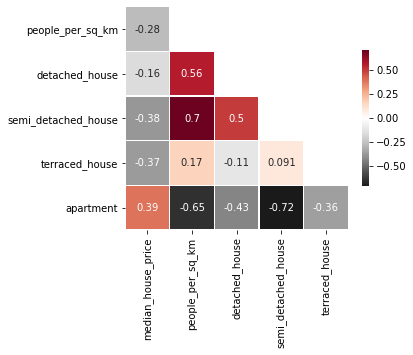

In [60]:
corr = correlations_heatmap(housing)

All indicators seem quite correlated to each other to a certain extent. `median_housing_price` is negatively correlated to most other indicators. We can already learn from this heatmap that when median price is high, the density of people and the number of semi-detached and terraced houses goes down, but that the number of detached houses and apartements goes up. So we can link high housing cost to apartement and detached houses. This is indeed quite representative of London housing market, where it is much cheaper to live in suburbs, there is mostly  But that is because we reversed that inicator  and `terraced_house` aren't that correlated with the rest of the indicators, but that the others are quite correlated.


In [61]:
#housing  =housing.drop(columns = ['detached_house', 'semi_detached_house', 'terraced_house', 'apartment'], axis = 1)


In [62]:
housing_weights = calculate_weights(housing)

housing_index = calculate_index_for_df(housing,housing_weights )

# Create a df to store the indexes 
ALDI = pd.DataFrame(housing_index)
ALDI = ALDI.rename(columns={'i' : 'Housing'})

housing_weights

Component cumulative variance: 53.55418748829288 %
Component cumulative variance: 74.83700756753724 %
Component cumulative variance: 82.90487249850578 %
Component cumulative variance: 90.30190409276621 %
Component cumulative variance: 96.14976377663054 %
Explained var [-0.7837159040716254, 0.2725023278907474, 1.3784801545532088, 0.3399433357604741, -0.7849903300437985]
Eigenvalues [0.21295316 0.08462912 0.0320811  0.0294136  0.02325346 0.0153101 ]


,weights
median_house_price,15.253691
people_per_sq_km,20.504379
detached_house,15.394386
semi_detached_house,4.572355
terraced_house,8.374931
apartment,13.972099


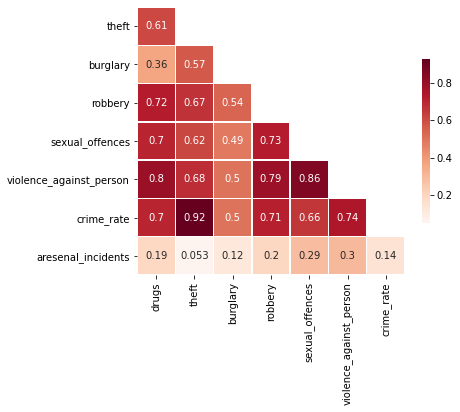

Component cumulative variance: 64.77132295410118 %
Component cumulative variance: 76.51415343534488 %
Component cumulative variance: 84.69028006968139 %
Component cumulative variance: 90.50989406709016 %
Component cumulative variance: 94.48152176801376 %
Component cumulative variance: 97.7018971941761 %
Explained var [-2.7179723985988167, -0.49651414287579343, 0.4573414185549237, -0.3020129089926321, 0.048273438479098416, -0.19638792970529345]
Eigenvalues [0.28236506 0.05119187 0.03564313 0.02537011 0.01731397 0.01403895
 0.00704116 0.00297722]


,weights
drugs,40.353968
theft,10.585406
burglary,19.828538
robbery,29.191168
sexual_offences,21.950266
violence_against_person,2.617318
crime_rate,12.373974
aresenal_incidents,15.080687


In [63]:
corr = correlations_heatmap(safety)
safety_weights = calculate_weights(safety)
safety_index = calculate_index_for_df(safety,safety_weights )
ALDI = ALDI.assign(Safety = safety_index.i)

safety_weights

Income, life satisaction, civic and work-life balance are all categories were we only have one sub-indicator, so no need to do any pca analysis. 

In [64]:
for cat in ['Income', 'Life_Satisfaction', 'Civic','Work_Life_Balance'] :
    ALDI = ALDI.merge(meta_data_indicators[cat],on='area_id', how='inner')
ALDI =  ALDI.rename(columns={'median_income' : 'Income', 'how_satisfied_are_you_score' : 'Life_Satisfaction', 
                                   'election_turnout' : 'Civic', 'part_time_employee_percent' : 'Work_Life_Balance' })


Jobs, community, education, environment and health  all have quite few sub-indicators, so we will perform pca on them, and add the indexes to `ALDI`.


Heatmap of correlations for Jobs


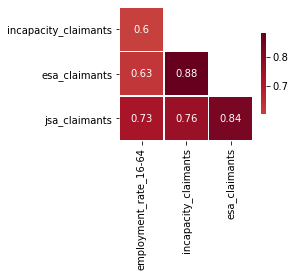

PCA for Jobs
Component cumulative variance: 81.14873463497986 %
Component cumulative variance: 92.28608570705748 %
Component cumulative variance: 97.4003606585798 %
Explained var [-1.992717446091142, -0.14928116564592525, -0.08075160660468439]
Eigenvalues [0.22336212 0.03065559 0.01407706 0.00715551]
                         weights
employment_rate_16-64  21.728195
incapacity_claimants   19.208966
esa_claimants           4.170992
jsa_claimants          41.659027

Heatmap of correlations for Community


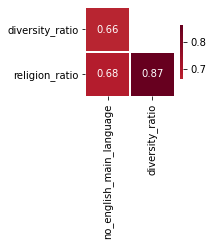

PCA for Community
Component cumulative variance: 81.79828588536506 %
Component cumulative variance: 96.0679865954634 %
Explained var [1.7281034579065435, 0.1050818849788746]
Eigenvalues [0.1575496  0.02748451 0.00757335]
                            weights
no_english_main_language  22.133966
diversity_ratio            7.063740
religion_ratio             7.186427

Heatmap of correlations for Education


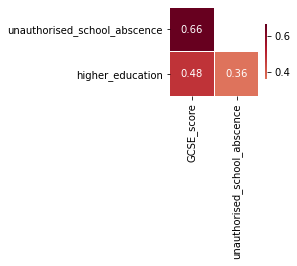

PCA for Education
Component cumulative variance: 66.3892705184141 %
Component cumulative variance: 89.90958547377365 %
Component cumulative variance: 100.0 %
Explained var [1.7297656504570513, -0.03402408300950066, 0.08217758985426091]
Eigenvalues [0.13257238 0.04696759 0.02014949]
                                weights
GCSE_score                    26.530549
unauthorised_school_abscence  22.023582
higher_education              13.499231

Heatmap of correlations for Environment


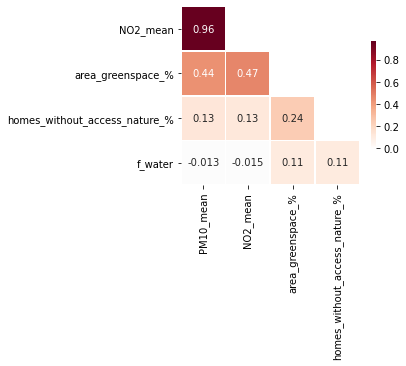

PCA for Environment
Component cumulative variance: 43.19195969761602 %
Component cumulative variance: 69.16020980260767 %
Component cumulative variance: 87.55078603646996 %
Component cumulative variance: 99.3787051793166 %
Explained var [-2.038253692956683, -0.5845014454700046, -0.6980222443579849, -0.12708143896505383]
Eigenvalues [0.14685776 0.08829512 0.06253013 0.04021632 0.00211248]
                                 weights
PM10_mean                       2.506739
NO2_mean                        2.216303
area_greenspace_%              18.438771
homes_without_access_nature_%   7.943565
f_water                        13.384323

Heatmap of correlations for Health


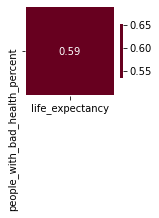

PCA for Health
Component cumulative variance: 79.64856274268459 %
Component cumulative variance: 100.0 %
Explained var [-1.4135358404784122, -0.043777022317524894]
Eigenvalues [0.09661496 0.02468661]
                                  weights
life_expectancy                 19.000574
people_with_bad_health_percent  21.507211

Heatmap of correlations for Alcohol


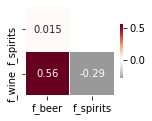

PCA for Alcohol
Component cumulative variance: 55.95253203205252 %
Component cumulative variance: 87.44242067259167 %
Component cumulative variance: 100.0 %
Explained var [-1.089820010000339, -1.2786710506233985, 0.42106138519284486]
Eigenvalues [0.09426777 0.05305357 0.02115677]
             weights
f_beer     18.950222
f_spirits  14.775071
f_wine     21.494622


,area_id,Names,Housing,Safety,Income,Life_Satisfaction,Civic,Work_Life_Balance,Jobs,Community,Education,Environment,Health,Alcohol
0,E05000029,Chadwell Heath,28.073446,109.600666,0.188386,0.020045,0.488171,0.824562,35.460279,21.787662,3.770833,21.914579,10.069261,40.922745
1,E05000042,Whalebone,24.639416,113.224209,0.309643,0.554566,0.594584,0.514172,51.416058,19.984682,19.181167,9.227330,23.986361,36.339325
2,E05000030,Eastbrook,28.101829,120.070543,0.317826,0.732739,0.548979,0.131582,38.956077,26.722624,14.497948,28.807817,10.405569,43.965544
3,E05000034,Heath,26.209642,99.060806,0.092421,0.376392,0.393159,0.949066,25.418938,23.965505,12.929273,15.020896,5.417856,43.720561
4,E05000040,Valence,23.241814,120.701848,0.161605,0.376392,0.336152,0.824562,42.929984,22.526367,6.559747,12.140951,2.209369,48.058617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,E05000295,Kenton West,24.209669,143.114286,0.355021,0.465479,0.666793,0.309213,67.724328,12.503332,32.385484,19.100673,26.590685,27.197680
628,E05011241,Cranbrook,27.690332,97.767330,0.350930,0.732739,0.556580,0.703948,52.513238,13.795885,47.380249,23.480079,18.044523,33.252673
629,E05011239,Clayhall,28.416247,108.570074,0.468468,0.732739,0.758005,0.473686,64.286892,16.407487,22.901819,19.172103,25.765586,35.827803
630,E05000222,Greenwich West,34.603464,75.453107,0.498968,0.821826,0.548979,0.595143,46.304028,16.472387,19.516117,31.076756,23.206254,43.184391


In [65]:
for cat in ['Jobs','Community','Education', 'Environment', 'Health','Alcohol']:
    print('\nHeatmap of correlations for', cat)
    corr = correlations_heatmap(meta_data_indicators[cat])
    print('PCA for', cat)
    weights = calculate_weights(meta_data_indicators[cat])
    index = calculate_index_for_df(meta_data_indicators[cat],weights )
    ALDI = ALDI.assign(new = index.i)
    ALDI =  ALDI.rename(columns={'new' : cat})
    print(weights)
ALDI

In [66]:
ALDI.shape

(632, 14)

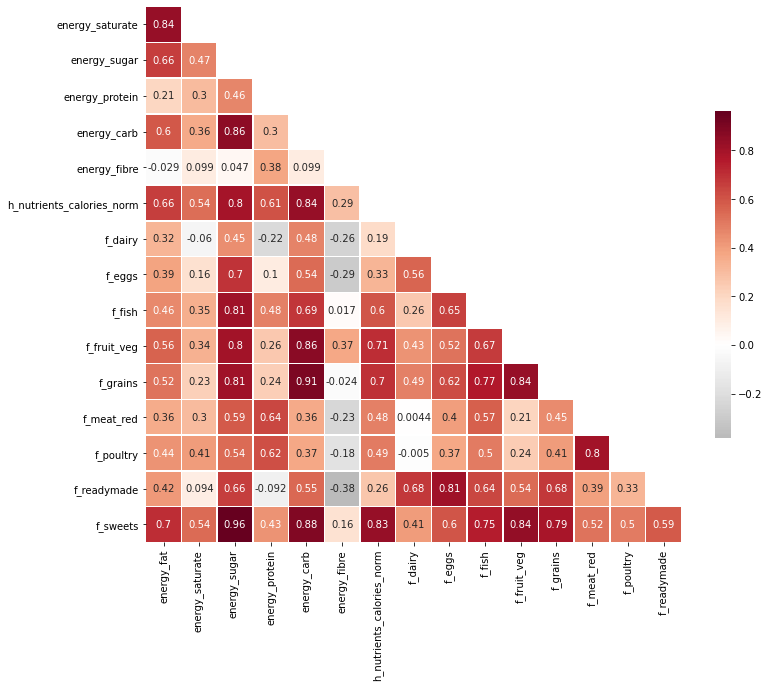

In [67]:
corr = correlations_heatmap(foods)

In [68]:
foods_weights = calculate_weights(foods)
foods_index = calculate_index_for_df(foods, foods_weights)
ALDI = ALDI.assign(new = foods_index.i)
ALDI =  ALDI.rename(columns={'new' : 'Foods'})
foods_weights

Component cumulative variance: 54.360968216821796 %
Component cumulative variance: 69.10824699226593 %
Component cumulative variance: 80.32127847571842 %
Component cumulative variance: 87.10460696243676 %
Component cumulative variance: 90.4306146613233 %
Component cumulative variance: 93.00852683002401 %
Component cumulative variance: 94.72708170846477 %
Component cumulative variance: 96.17593757801286 %
Explained var [-3.7519156481298634, -0.5189489112748724, 0.13956316957599219, -0.012601471786863397, 0.3048460572095834, -0.850236496575871, 0.36468958695175924, -0.194472916359029]
Eigenvalues [0.52932026 0.14359629 0.10918284 0.06605021 0.0323858  0.02510149
 0.01673381 0.01410771 0.0122136  0.00829472 0.00593591 0.00372473
 0.00264559 0.00187095 0.00137842 0.00117149]


,weights
energy_fat,5.264862
energy_saturate,5.656009
energy_sugar,1.613730
energy_protein,4.924358
energy_carb,4.321933
energy_fibre,6.906443
h_nutrients_calories_norm,4.618835
f_dairy,14.838336
f_eggs,30.179868
f_fish,9.134585


## Computing the weights for the indicators <a class="anchor" id="weights2"></a>

[Back to index](#3-bullet)

In [69]:
ALDI

,area_id,Names,Housing,Safety,Income,Life_Satisfaction,Civic,Work_Life_Balance,Jobs,Community,Education,Environment,Health,Alcohol,Foods
0,E05000029,Chadwell Heath,28.073446,109.600666,0.188386,0.020045,0.488171,0.824562,35.460279,21.787662,3.770833,21.914579,10.069261,40.922745,55.715335
1,E05000042,Whalebone,24.639416,113.224209,0.309643,0.554566,0.594584,0.514172,51.416058,19.984682,19.181167,9.227330,23.986361,36.339325,48.119905
2,E05000030,Eastbrook,28.101829,120.070543,0.317826,0.732739,0.548979,0.131582,38.956077,26.722624,14.497948,28.807817,10.405569,43.965544,55.502661
3,E05000034,Heath,26.209642,99.060806,0.092421,0.376392,0.393159,0.949066,25.418938,23.965505,12.929273,15.020896,5.417856,43.720561,25.505091
4,E05000040,Valence,23.241814,120.701848,0.161605,0.376392,0.336152,0.824562,42.929984,22.526367,6.559747,12.140951,2.209369,48.058617,43.127180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,E05000295,Kenton West,24.209669,143.114286,0.355021,0.465479,0.666793,0.309213,67.724328,12.503332,32.385484,19.100673,26.590685,27.197680,45.735590
628,E05011241,Cranbrook,27.690332,97.767330,0.350930,0.732739,0.556580,0.703948,52.513238,13.795885,47.380249,23.480079,18.044523,33.252673,50.724269
629,E05011239,Clayhall,28.416247,108.570074,0.468468,0.732739,0.758005,0.473686,64.286892,16.407487,22.901819,19.172103,25.765586,35.827803,41.256579
630,E05000222,Greenwich West,34.603464,75.453107,0.498968,0.821826,0.548979,0.595143,46.304028,16.472387,19.516117,31.076756,23.206254,43.184391,44.127647


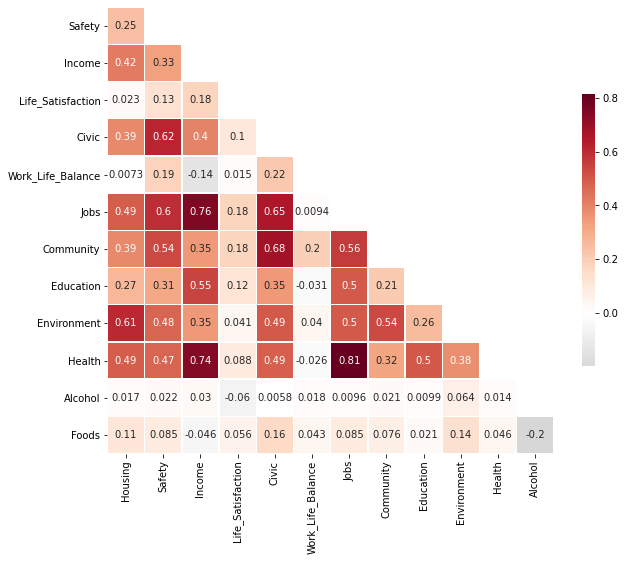

In [70]:
correlations_heatmap(ALDI)

In [71]:
ALDI.isna().sum()


area_id              0
Names                0
Housing              0
Safety               0
Income               0
Life_Satisfaction    0
Civic                0
Work_Life_Balance    2
Jobs                 0
Community            0
Education            1
Environment          0
Health               0
Alcohol              0
Foods                0
dtype: int64

In [72]:
ALDI.Education = ALDI.Education.fillna(ALDI.Education.mean())
ALDI.Work_Life_Balance = ALDI.Work_Life_Balance.fillna(ALDI.Work_Life_Balance.mean())

In [73]:
ALDI = normalize(ALDI, norm, remove_outliers = False)

In [74]:
final_weigths = calculate_weights(ALDI)
final_index = calculate_index_for_df(ALDI, final_weigths)
ALDI = ALDI.assign(final = final_index.i)
final_weigths


Component cumulative variance: 38.424266684159754 %
Component cumulative variance: 50.899592195944635 %
Component cumulative variance: 62.075527429654755 %
Component cumulative variance: 69.63420605622284 %
Component cumulative variance: 76.28179968752139 %
Component cumulative variance: 81.25851623826922 %
Component cumulative variance: 85.74616729134003 %
Component cumulative variance: 89.73966346903883 %
Component cumulative variance: 93.07997347280822 %
Component cumulative variance: 95.70576783943021 %
Explained var [3.117215457613909, -0.692469524328605, 0.48220843979234335, 0.17931599790733888, -0.2847482940124286, -1.512750219740945, -0.002236538522044307, 0.21402414421667018, -0.08781702069076561, 0.20402290801389922]
Eigenvalues [0.24989376 0.08113378 0.07268314 0.04915817 0.04323289 0.03236628
 0.02918562 0.02597186 0.02172384 0.01707696 0.0120339  0.00889414
 0.00699966]


,weights
Housing,9.338310
Safety,18.992765
Income,5.794225
Life_Satisfaction,12.932112
Civic,28.137239
Work_Life_Balance,8.712051
Jobs,2.937565
Community,9.618916
Education,20.918276
Environment,6.240153


In [75]:
ALDI.final = (ALDI.final - min(ALDI.final)) / ( max(ALDI.final)-min(ALDI.final)) 
ALDI

,area_id,Names,Housing,Safety,Income,Life_Satisfaction,Civic,Work_Life_Balance,Jobs,Community,Education,Environment,Health,Alcohol,Foods,final
0,E05000029,Chadwell Heath,0.377964,0.706516,0.188386,0.020045,0.488171,0.824562,0.408683,0.598823,0.060768,0.439407,0.240289,0.706268,0.463695,0.340583
1,E05000042,Whalebone,0.293992,0.732037,0.309643,0.554566,0.594584,0.514172,0.592575,0.549269,0.309108,0.124352,0.587644,0.604055,0.390079,0.442825
2,E05000030,Eastbrook,0.378658,0.780257,0.317826,0.732739,0.548979,0.131582,0.448972,0.734458,0.233637,0.610582,0.248683,0.774124,0.461634,0.488787
3,E05000034,Heath,0.332389,0.632282,0.092421,0.376392,0.393159,0.949066,0.292956,0.658680,0.208357,0.268220,0.124195,0.768661,0.170894,0.343087
4,E05000040,Valence,0.259816,0.784703,0.161605,0.376392,0.336152,0.824562,0.494772,0.619126,0.105711,0.196704,0.044115,0.865401,0.341689,0.349614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,E05000295,Kenton West,0.283483,0.942557,0.355021,0.465479,0.666793,0.309213,0.780529,0.343648,0.521897,0.369531,0.652645,0.400192,0.366970,0.490513
628,E05011241,Cranbrook,0.368596,0.623172,0.350930,0.732739,0.556580,0.703948,0.605220,0.379173,0.763540,0.478282,0.439342,0.535222,0.415321,0.551899
629,E05011239,Clayhall,0.386347,0.699257,0.468468,0.732739,0.758005,0.473686,0.740913,0.450952,0.369067,0.371304,0.632051,0.592648,0.323559,0.539235
630,E05000222,Greenwich West,0.537644,0.466009,0.498968,0.821826,0.548979,0.595143,0.533658,0.452735,0.314505,0.666925,0.568173,0.756704,0.351386,0.500262


In [76]:
ALDI.to_csv('ALDI_'+norm+'.csv', index=False)
final_weigths.to_csv('weights_'+norm, index=False)

In [77]:
ALDI_standardization = pd.read_csv('ALDI_standardize.csv')
ALDI_re_scale = pd.read_csv('ALDI_re_scale.csv')


In [78]:
validation.columns

Index(['Old Ward Code', 'New ward code', 'Ward name', 'Borough',
       'Life Expectancy 2009', 'Life Expectancy 2010', 'Life Expectancy 2011',
       'Life Expectancy 2012', 'Life Expectancy 2013',
       'Childhood Obesity 2009', 'Childhood Obesity 2010',
       'Childhood Obesity 2011', 'Childhood Obesity 2012',
       'Childhood Obesity 2013', 'Incapacity Benefit rate 2009',
       'Incapacity Benefit rate 2010', 'Incapacity Benefit rate 2011',
       'Incapacity Benefit rate 2012', 'Incapacity Benefit rate 2013',
       'Unemployment rate 2009', 'Unemployment rate 2010',
       'Unemployment rate 2011', 'Unemployment rate 2012',
       'Unemployment rate 2013', 'Crime rate - Index 2009',
       'Crime rate - Index 2010', 'Crime rate - Index 2011',
       'Crime rate - Index 2012', 'Crime rate - Index 2013',
       'Deliberate Fires 2009', 'Deliberate Fires 2010',
       'Deliberate Fires 2011', 'Deliberate Fires 2012',
       'Deliberate Fires 2013',
       'Average Capped GCSE an

In [79]:
columns_val = ['Life Expectancy 2013', 'Childhood Obesity 2013','Incapacity Benefit rate 2013', 
               'Unemployment rate 2013', 'Crime rate - Index 2013','Deliberate Fires 2013',
           'Average Capped GCSE and Equivalent Point Score Per Pupil 2013', 'Unauthorised Absence in All Schools (%) 2013',
               'Dependent children in out-of-work families 2013', 'Public Transport Accessibility 2013',
               'Homes with access to open space & nature, and % greenspace 2013', 'Subjective well-being average score 2013',
               'New ward code']

merged_ALDI = ALDI_standardization.loc[:, ['area_id','final']].merge(ALDI_re_scale.loc[:,['area_id','final']], on = 'area_id')
merged_ALDI = merged_ALDI.rename(columns={'final_x': "final_standardized", 'final_y': "final_re_scaled"})
merged_validation = merged_ALDI.merge(validation.loc[:,columns_val], left_on = 'area_id', right_on = 'New ward code' )
merged_validation = merged_validation.merge(ward_total_wellbeing.loc[:,columns_wellbeing], on = 'New ward code')

NameError: name 'ward_total_wellbeing' is not defined

In [ ]:
merged_validation

In [ ]:
total_corr = correlations_heatmap(merged_validation)

In [ ]:
sum(total_corr.final_standardized)

In [ ]:
sum(total_corr.final_re_scaled)

In [ ]:
corr = correlations_heatmap(ALDI_standardization)

In [ ]:
corr = correlations_heatmap(ALDI_re_scale)